# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.vision.learner import model_meta
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

TRAIN_LR_NAME = 'train_lr'
TRAIN_LR = PATH/TRAIN_LR_NAME

TRAIN_MR_NAME = 'train_mr'
TRAIN_MR = PATH/TRAIN_MR_NAME

SUPERRES_MODELS_NAME = 'models_superres'
SUPERRES_MODELS = PATH/SUPERRES_MODELS_NAME

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
seed = 42
np.random.seed(seed)

def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
        return [func(channel_view(x), 1) for func in funcs]
    
    
vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 96
bs = 128
epochs_frozen = 1
epochs_unfrozen = 20

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults


# Crappify images

In [2]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn
        img = PIL.Image.open(self.path_hr/fn)
        dest.parent.mkdir(parents=True, exist_ok=True)
        targ_sz = resize_to(img, 48, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        #q = random.randint(10,70)
        img.save(dest, quality=60)

In [3]:
fnames = [os.path.split(p)[-1] for p in list(TRAIN.iterdir())]

In [4]:
parallel(crappifier(TRAIN_LR, TRAIN), fnames)

In [4]:
parallel(crappifier(TRAIN_MR, TRAIN), fnames)

# Data

In [2]:
src = ImageImageList.from_folder(TRAIN_LR).split_by_rand_pct(0.1, seed=seed)

In [63]:
tfms = ([ RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
        [])

In [4]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: TRAIN/x.name)
           .transform(tfms, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))

    data.c = 3
    return data

In [5]:
data = get_data(bs,sz)

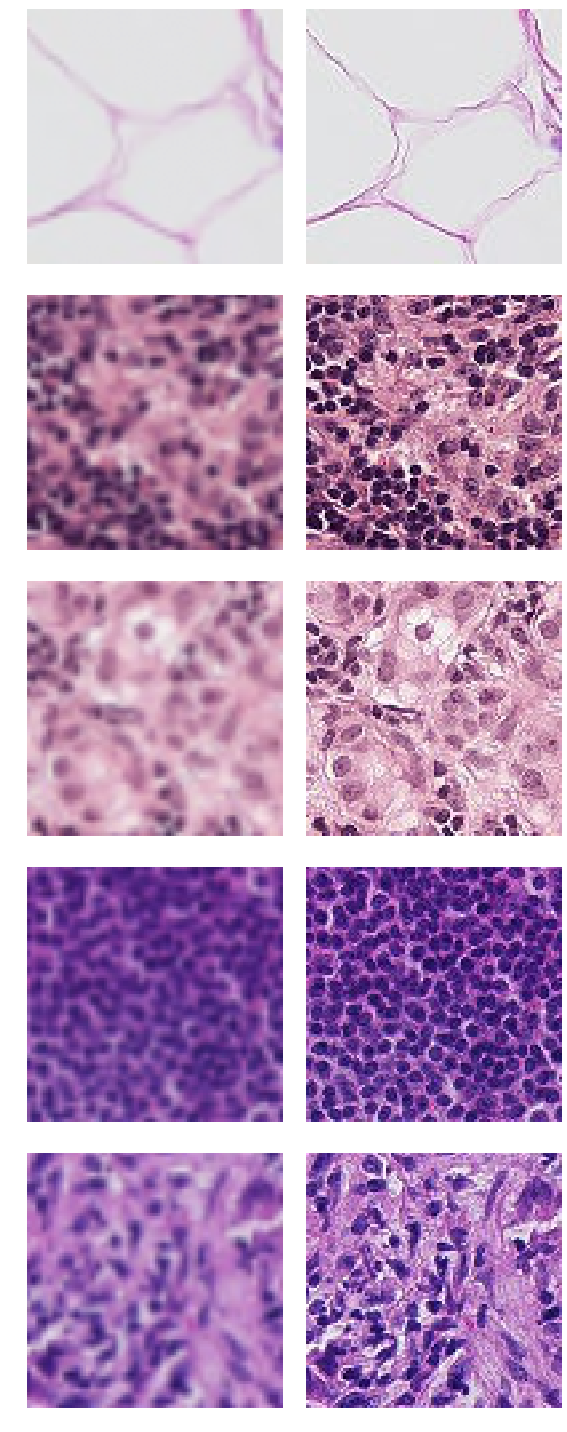

In [6]:
data.show_batch()

# Feature Loss 

In [28]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

gram_matrix(t)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train 

In [26]:
arch = torchvision.models.resnet34

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


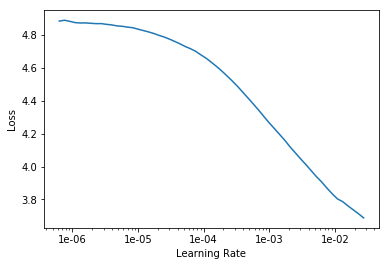

In [18]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 1e-3

In [24]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [17]:
path_frozen = SUPERRES_MODELS/'1-superres-frozen'

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.727332,1.725091,0.353947,0.165452,0.188715,0.058353,0.307044,0.568488,0.083093,16:43
1,1.673646,1.664127,0.346904,0.158125,0.182397,0.056398,0.291334,0.548354,0.080616,16:42
2,1.646920,1.639880,0.340632,0.155593,0.179957,0.055800,0.286750,0.541394,0.079754,16:43
3,1.629948,1.626802,0.346181,0.153628,0.177702,0.055270,0.281128,0.533751,0.079141,16:42
4,1.612517,1.605993,0.336292,0.153575,0.176872,0.054923,0.277305,0.528149,0.078877,16:42
5,1.606552,1.607376,0.334007,0.152683,0.176390,0.054723,0.282593,0.528627,0.078353,17:15
6,1.600731,1.594923,0.334678,0.151761,0.175015,0.054321,0.277146,0.524345,0.077657,16:51
7,1.594450,1.590395,0.334700,0.150342,0.173882,0.054159,0.277303,0.522540,0.077469,16:52
8,1.588945,1.581465,0.333678,0.150328,0.173587,0.053854,0.273580,0.519417,0.077021,16:50
9,1.558436,1.551049,0.331421,0.148617,0.171183,0.053019,0.261896,0.508981,0.075931,17:05


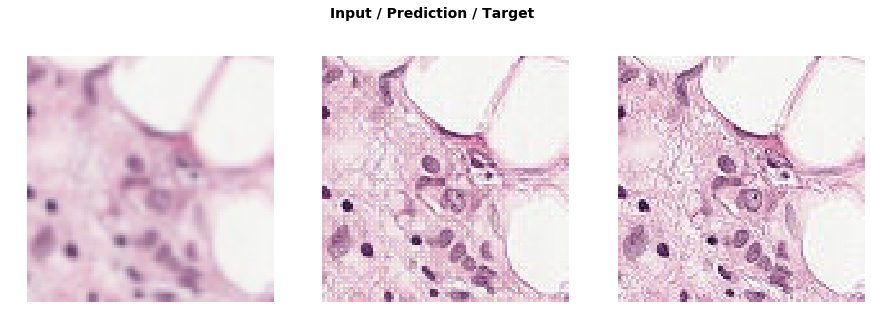

In [22]:
do_fit(path_frozen, slice(lr*10))

In [15]:
learn.load(path_frozen)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (198023 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr;

Valid: LabelList (22002 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(ke

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


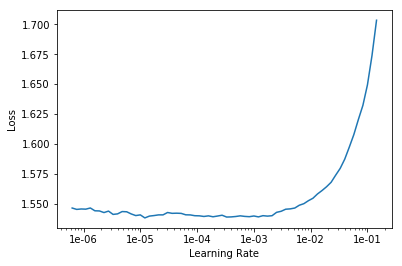

In [19]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr2 = 1e-5
lr3 = lr

In [32]:
path_unfrozen = SUPERRES_MODELS/'1-superres-unfrozen'

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.527979,1.525922,0.323257,0.146656,0.168896,0.051666,0.258038,0.503160,0.074248,17:24
1,1.527773,1.525008,0.323188,0.146589,0.168789,0.051625,0.257774,0.502844,0.074199,17:15
2,1.529104,1.524647,0.322703,0.146376,0.168671,0.051595,0.258431,0.502774,0.074098,17:17
3,1.527197,1.523680,0.322774,0.146444,0.168601,0.051638,0.257537,0.502403,0.074283,17:16
4,1.528532,1.523129,0.321785,0.146466,0.168677,0.051601,0.257905,0.502535,0.074160,17:17
5,1.524544,1.522530,0.323092,0.146192,0.168520,0.051561,0.256854,0.502185,0.074124,17:17
6,1.523441,1.521213,0.321321,0.146048,0.168398,0.051564,0.258010,0.501701,0.074172,17:17
7,1.522901,1.519633,0.322519,0.145960,0.168055,0.051458,0.256572,0.501092,0.073977,17:16
8,1.522187,1.519570,0.323028,0.145946,0.168005,0.051417,0.256373,0.500951,0.073851,17:17
9,1.513705,1.514268,0.321696,0.145693,0.167662,0.051282,0.255175,0.499041,0.073720,17:16


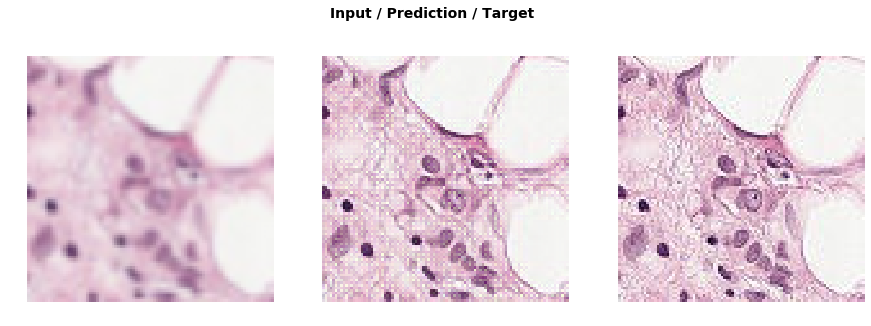

In [25]:
do_fit(path_unfrozen, slice(1e-5,lr))

# Upsample original sized images 

In [88]:
data_test = (ImageImageList.from_folder(TRAIN_LR)
.split_none()
.label_from_func(lambda x: TRAIN/x.name)
.transform(size = sz)
.databunch(bs=bs).normalize())

In [89]:
data_test.c = 3

In [90]:
learn_test = unet_learner(data_test, arch, wd=wd,
                     blur=True, norm_type=NormType.Weight)

In [91]:
learn_test.load(path_unfrozen)

Learner(data=ImageDataBunch;

Train: LabelList (220025 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 48, 48),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

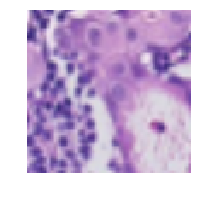

In [100]:
img = data_test.train_ds[10][0]; img.show()

In [93]:
pred = learn_test.predict(img)

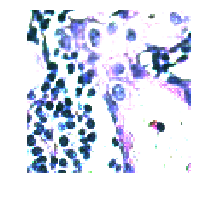

In [98]:
pred[0].show()

In [ ]:
pred.

In [99]:
learn_test.show_results()

IndexError: Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "../fastai/fastai/data_block.py", line 630, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "../fastai/fastai/data_block.py", line 106, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "../fastai/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "../fastai/fastai/data_block.py", line 66, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0
